# Data Cleaning

Real-world data science teams spend most of their time cleaning and preparing data for machine learning algorithms. Even more than the amount of time they spend training the algorithms themselves.

Data preparation can dramatically improve the performance of many machine-learning algorithms.

A data pipeline is an artifact that transforms dirty input data to clean, usable data for the algorithms. Pipelines perform some actions like `normalization`, `discretization`, `filling na values`, `dimensionality reduction`, and, some other stuff to the input data to make it ready for the algorithm.

In this notebook you will learn how to use `scikit-learn` to build data piplelines.

In [1]:
# Useful libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

np.random.seed(0)

# Table of Concepts

1. [Filling na Values](#Filling_na_Values)
    1. [Generating the fake data](#Generating-the-fake-data)
    2. [SimpleImputer](#SimpleImputer)
    3. [KNNImputer](#KNNImputer)
2. [Normalization](#Normalization)
    1. [MinMaxScaler](#MinMaxScaler)
    2. [StandardScaler](#StandardScaler)
    3. [RobustScaler](#RobustScaler)
    4. [Normalizer](#Normalizer)
3. [Discretization](#Discretization)
4. [Data Pipeline](#Data-Pipeline)
    1. [Pipeline](#Pipeline)
    2. [ColumnTransformer](#ColumnTransformer)

# Filling na Values

## Generating the fake data

Sometimes, you found data points in dataframes that do not have any value for a specific column or they have invalid values like `np.nan`, we call these values `null values`, `nan values`, or `na values` (not a number).

There are different strategies to cope with these values and we will take a look at some of them.

We will use the `sklearn.impute.SimpleImputer` to deal with `nan` values. Take a look at [this link](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) from the official document for more details.

In [2]:
# Importing the module
from sklearn.impute import SimpleImputer

Let's define some fake data for later use.

In [3]:
x = np.linspace(-5, 5, 500)
y = .5 * stats.norm.pdf(x, 2, .5) + .5 * stats.norm.pdf(x, -2, 1.)

chance = .2 # You can change this value to change the amount of null values
null = np.random.uniform(low=0, high=1, size=x.shape)
null_x = np.where(null >= chance, x, [np.nan]) 

ground_truth_data = np.vstack([x, y]).T# Actual data (numpy.ndarray)
null_data = np.vstack([null_x, y]).T# Data with null values (numpy.ndarray)

df = pd.DataFrame(null_data, columns=['x', 'y'])# Actual data (pandas.core.frame.DataFrame)
ground_truth_df = pd.DataFrame(ground_truth_data, columns=['x', 'y'])# Data with null values (pandas.core.frame.DataFrame)

Let's plot the data:

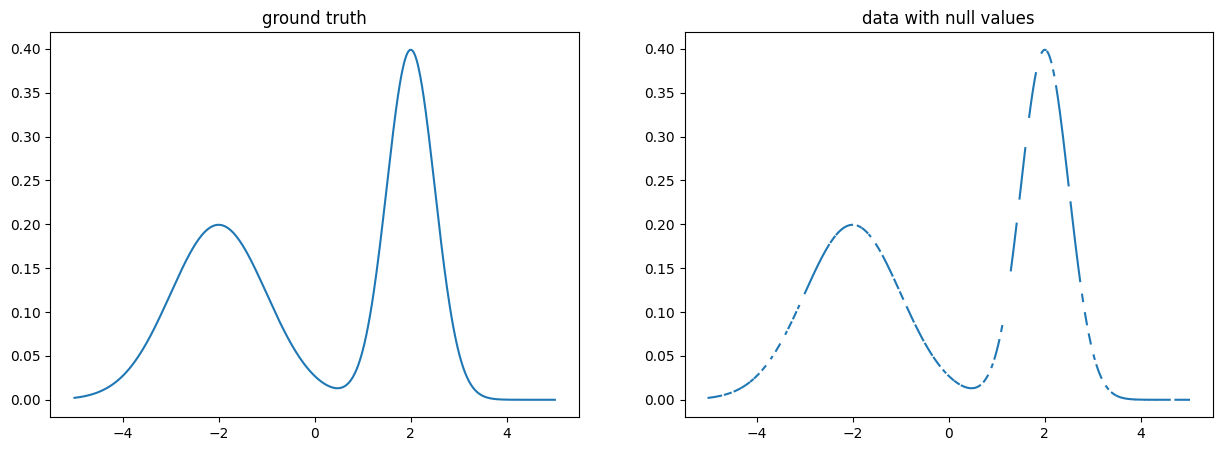

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(ground_truth_df['x'], ground_truth_df['y'], label='ground truth')
axs[0].title.set_text('ground truth')

axs[1].plot(df['x'], df['y'], label='null data')
axs[1].title.set_text('data with null values')

plt.show()

## SimpleImputer

`SimpleImputer` can implement the following strategies to cope with null values:

1. Fill in them with some constant value (strategy='constant', fill_value=*some_value*)
2. Fill in them with the mean of the data (strategy='mean')
3. Fill in them with the median of the data (strategy='median')
4. Fill in them with the most frequent data (strategy='most_frequent')

You should pass at least two parameters to the constructor of `SimpleImputer`. The first one is the `missing_values` which is the value that you want to replace, and the second one is the strategy.


Let's test them:

In [5]:
constant = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
mean = SimpleImputer(missing_values=np.nan, strategy='mean')
median = SimpleImputer(missing_values=np.nan, strategy='median')
most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

After that, you have defined the `SimpleImputer` object you should call the `fit` method. This method calculates the necessary parameters (mean and standard deviation of the data) then, you can transform new data points with the `transform` method.

In [6]:
constant.fit(df)

SimpleImputer(fill_value=-1, strategy='constant')

In [7]:
mean.fit(df)

SimpleImputer()

In [8]:
median.fit(df)

SimpleImputer(strategy='median')

In [9]:
most_frequent.fit(df)

SimpleImputer(strategy='most_frequent')

In [10]:
transformed_x_with_constant = constant.transform(df)
transformed_x_with_mean = mean.transform(df)
transformed_x_with_median = median.transform(df)
transformed_x_with_the_most_frequent = most_frequent.transform(df)

To see the result, we will plot transformed dfs.

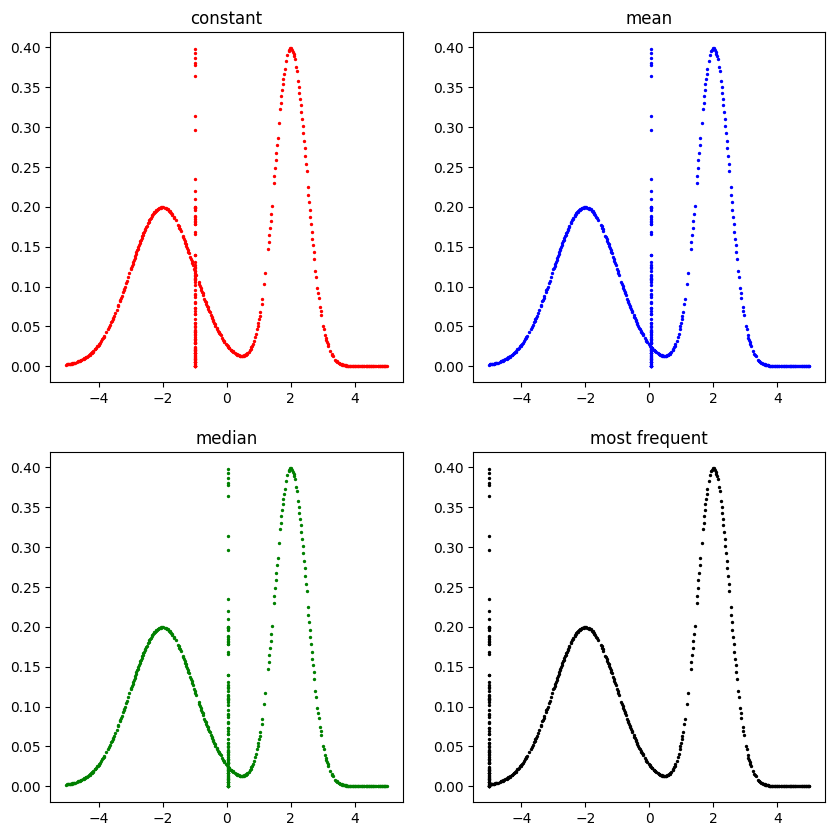

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].scatter(transformed_x_with_constant[:, 0],
                  transformed_x_with_constant[:, 1],
                  color='red',
                  s=2)
axs[0, 0].title.set_text('constant')

axs[0, 1].scatter(transformed_x_with_mean[:, 0],
                  transformed_x_with_mean[:, 1],
                  color='blue',
                  s=2)
axs[0, 1].title.set_text('mean')

axs[1, 0].scatter(transformed_x_with_median[:, 0],
                  transformed_x_with_median[:, 1],
                  color='green',
                  s=2)
axs[1, 0].title.set_text('median')

axs[1, 1].scatter(transformed_x_with_the_most_frequent[:, 0],
                  transformed_x_with_the_most_frequent[:, 1],
                  color='black',
                  s=2)
axs[1, 1].title.set_text('most frequent')

plt.show()

As you can see non of the above methods can fill the data in order for the new value to have a meaningful full value. (These methods are perfectly fine for some methods like tree-based algorithms, but it is obvious that you can do better than simply replacing the value).

## KNNImputer

One of the methods that can perform better is the `KNNImputer`. This algorithm uses the KNN (k-nearest neighbor) to fill out the missing values. You can read more about this algorithm [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

Let's take a quick look at this algorithm:

In [12]:
from sklearn.impute import KNNImputer

In [13]:
knn_imputer = KNNImputer(missing_values=np.nan, weights='distance', n_neighbors=1)

knn_imputer.fit(df)

KNNImputer(n_neighbors=1, weights='distance')

In [14]:
transformed_x_with_knn_imputer = knn_imputer.transform(df)

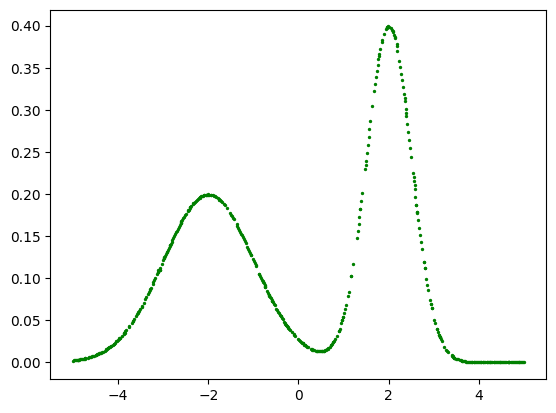

In [15]:
plt.scatter(transformed_x_with_knn_imputer[:, 0],
            transformed_x_with_knn_imputer[:, 1],
            s=2,
            color='green')

plt.show()

As you can see, this method performs better on this data.

# Normalization

One of the most important steps in preprocessing data is normalization. Machine learning algorithms usually perform better on normalized data. There are many reasons for this, which are out of the scope of this tutorial.

## MinMaxScaler

The very first normalizing strategy is to normalize data points according to their max and min value as below:

$$ x_i = \frac{x_i - min(x_j)_{j=1}^{m}}{max(x_j)_{j=1}^{m}} $$

m = #Training Datapoints

In [16]:
from sklearn.preprocessing import MinMaxScaler

To use the `MinMaxScaler` you should first initiate an instance of it, then use the `fit` method to train the scaler. Afterward, you can use the `transform` method to scale new data points.

In [17]:
minmax_scaler = MinMaxScaler()

In [18]:
data = np.array([[1], [2], [1], [4], [-1], [3]])

minmax_scaler.fit(data)

MinMaxScaler()

In [19]:
minmax_scaler.transform(np.array([[0], [1], [2]]))

array([[0.2],
       [0.4],
       [0.6]])

You can read more about this scaler from [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

## StandardScaler

This scaler scales the data concerning the z-score.

z-score is defined as:

$$ x_i = \frac{x_i - \mu}{\sigma} $$

where:

$$ \mu = \frac{1}{m}\sum_{i=1}^{m}{x_i} $$
$$ \sigma = \sqrt{\frac{1}{m-1}\sum_{j=1}^{m}{(x_i - \mu)}^{2}} $$

Note that coefficient $\frac{1}{m-1}$ is to estimate an unbiased estimation of the standard deviation. You can read more about this [here](https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation).

In [20]:
from sklearn.preprocessing import StandardScaler

To use the `StandardScaler` you should first initiate an instance of it, then use the `fit` method to train the scaler. Afterward, you can use the `transform` method to scale new data points.

In [21]:
standard_scaler = StandardScaler()

In [22]:
data = np.array([[1], [2], [1], [4], [-1], [3]])

standard_scaler.fit(data)

StandardScaler()

In [23]:
standard_scaler.transform(np.array([[0], [1], [2]]))

array([[-1.04257207],
       [-0.41702883],
       [ 0.20851441]])

You can read more about this scaler from [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

## RobustScaler

Let's test `StandardScaler` with some data that has an outlier:

In [24]:
data = np.array([[1], [2], [1], [4], [-1], [3], [10000]])

standard_scaler.fit(data)

StandardScaler()

In [25]:
standard_scaler.transform(np.array([[0], [1], [2]]))

array([[-0.40872462],
       [-0.4084388 ],
       [-0.40815298]])

It is obvious that, the output of the scaler changes dramatically when an outlier is added.

The `RobustScaler` can handle this problem:

In [26]:
from sklearn.preprocessing import RobustScaler

Now let's test this scaler in action:

In [27]:
data = np.array([[1], [2], [1], [4], [-1], [3]])
noisy_data = np.array([[1], [2], [1], [4], [-1], [3], [10000]])

In [28]:
robust_scaler = RobustScaler()

robust_scaler.fit(data)
robust_scaler.transform(np.array([[0], [1], [2]]))

array([[-0.85714286],
       [-0.28571429],
       [ 0.28571429]])

In [29]:
robust_scaler.scale_, robust_scaler.center_

(array([1.75]), array([1.5]))

In [30]:
robust_scaler = RobustScaler()

robust_scaler.fit(noisy_data)
robust_scaler.transform(np.array([[0], [1], [2]]))

array([[-0.8],
       [-0.4],
       [ 0. ]])

You can read more about this scaler [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).

## Normalizer

The last scaler that we will look at, is the `Normalizer`. This scaler, scalers every individual data point to a normal vector.

In [31]:
from sklearn.preprocessing import Normalizer

Note that there is no need to use the `fit` function.

In [32]:
normalizer = Normalizer()

In [33]:
normalizer.transform(np.array([[2, 1], [1, 1], [2, 2]]))

array([[0.89442719, 0.4472136 ],
       [0.70710678, 0.70710678],
       [0.70710678, 0.70710678]])

# Discretization

Some machine learning algorithms (like tree-based algorithms) work better on discrete data. For this and some other reasons, sometimes it would be a good choice to convert a continuous value to a discrete value.

You can use `KBinsDiscretizer` to do so.

In [34]:
from sklearn.preprocessing import KBinsDiscretizer

There are two import parameters that you can tune while using this algorithm. The first one is `n_bins` which defines the number of bines that should be used to discretize the data. The second one is `encode` which sets the encoding strategy which can be one of the followings: `onehot`, `onehot-dense`, and `ordinal`.

I highly recommend you read the documentation from [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html).

Let's test this algorithm:

In [35]:
bins = KBinsDiscretizer(n_bins=4, encode='ordinal')

In [36]:
data = np.array([[1], [2], [3], [3], [-1], [4], [5], [6], [-2], [2]])

In [37]:
bins.fit(data)

KBinsDiscretizer(encode='ordinal', n_bins=4)

In [38]:
bins.transform(np.array([[1], [2], [10], [-10]]))

array([[0.],
       [1.],
       [3.],
       [0.]])

# OrdinalEncoder

In Order to convert categorical data to numeric values you can use the `OrdinalEncoder`

In [46]:
from sklearn.preprocessing import OrdinalEncoder

In [53]:
encoder = OrdinalEncoder()

In [58]:
encoder.fit(np.array([['val1'], ['val2'], ['val2']]))

OrdinalEncoder()

In [60]:
encoder.transform(np.array([['val1'], ['val2']]))

array([[0.],
       [1.]])

You can read more about this algorithm [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

# Data Pipeline

## Pipeline

You can combine different preprocessing steps with a `Pipeline`.

You should pass a list of the preprocessing steps to the pipeline. Each item of the list should be a tuple of the form: (name, transform).

In [39]:
from sklearn.pipeline import Pipeline

In [41]:
pipeline = Pipeline([
    ('nan', KNNImputer()),
    ('z-score', StandardScaler())
])

Now you can use `fit` to train the pipleline. After that you can use `transform` to transform new data points.

You can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

## ColumnTransformer

You can build pipeline for specific columns of that dataframe with the `ColumnTransformer`. You should pass a list of the preprocessing steps to the pipeline. Each item of the list should be a tuple of the form: (name, transform, column_names).

In [42]:
from sklearn.compose import ColumnTransformer

In [43]:
column_transform = ColumnTransformer([
    ('nan', KNNImputer(), ['column1', 'column2']),
])

Now you can use `fit` to train the pipleline. After that you can use `transform` to transform new data points.

You can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

## Put it all together

You can also combine `ColumnTransformer` and `Pipeline` to build data pipelines.

As an example:

In [49]:
categorical_columns_transormer = Pipeline([
    ('categories', OrdinalEncoder()),
    
])

continuous_columns_transformer = Pipeline([
    ('normalizer', StandardScaler()),
    ('bins', KBinsDiscretizer(encode='ordinal', n_bins=3))]
)

pipeline = ColumnTransformer([
    ('continuous', continuous_columns_transformer, ['continuous_columns1', 'continuous_columns2', 'continuous_columns3']),
    ('categorical', categorical_columns_transormer, ['categorical_columns1', 'categorical_columns2'])
])

In [50]:
pipeline

ColumnTransformer(transformers=[('continuous',
                                 Pipeline(steps=[('normalizer',
                                                  StandardScaler()),
                                                 ('bins',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3))]),
                                 ['continuous_columns1', 'continuous_columns2',
                                  'continuous_columns3']),
                                ('categorical',
                                 Pipeline(steps=[('categories',
                                                  OrdinalEncoder())]),
                                 ['categorical_columns1',
                                  'categorical_columns2'])])